In [15]:
1+1

2

In [64]:
import matplotlib.pyplot as plt
import numpy as np

class CaroEnv:
    def __init__(self, board_size=10):
        self.board_size = board_size
        self.reset()

    def reset(self):
        self.board = np.zeros((self.board_size, self.board_size), dtype=int)
        self.done = False
        self.current_player = 1
        self.last_move = None
        self.winning_coords = []

        # ✅ Agent mặc định đánh trước tại ô cố định (ví dụ: giữa bàn)
        x0, y0 = self.board_size // 2, self.board_size // 2
        self.board[x0, y0] = self.current_player
        self.last_move = (x0, y0)
        self.current_player *= -1  # Đổi lượt cho đối thủ

        return self.board.copy()

    def step(self, action):
        x, y = action
        if self.board[x, y] != 0 or self.done:
            return self.board.copy(), 0, False, {"invalid": True}

        self.board[x, y] = self.current_player
        self.last_move = (x, y)

        win, coords = self.check_win(x, y)
        if win:
            self.done = True
            self.winning_coords = coords
            reward = 3 if self.current_player == 1 else -1
            reward = max(min(reward, 4), -1)
            return self.board.copy(), reward, True, {"winner": self.current_player}

        elif np.all(self.board != 0):
            self.done = True
            return self.board.copy(), 1, True, {"winner": 0}

        else:
            reward = 0.0
            longest_chain = self.get_longest_chain(x, y)
            reward += min(0.1 * (longest_chain - 1), 0.5)

            if self.current_player == 1:
                threat_map = self.get_threat_map()
                if threat_map[x, y] >= 4:
                    reward += 0.75
                elif threat_map[x, y] == 3:
                    reward += 0.5

            reward = max(min(reward, 4), -1)
            self.current_player *= -1
            return self.board.copy(), reward, False, {}

    def get_longest_chain(self, x, y):
        directions = [(1, 0), (0, 1), (1, 1), (1, -1)]
        player = self.board[x, y]
        max_len = 0

        for dx, dy in directions:
            count = 1
            for d in [1, -1]:
                nx, ny = x + d*dx, y + d*dy
                while 0 <= nx < self.board_size and 0 <= ny < self.board_size and self.board[nx, ny] == player:
                    count += 1
                    nx += d * dx
                    ny += d * dy
            if count > max_len:
                max_len = count

        return max_len

    def get_threat_map(self):
        threat_map = np.zeros_like(self.board, dtype=float)
        opponent = -self.current_player

        for i in range(self.board_size):
            for j in range(self.board_size):
                if self.board[i, j] == 0:
                    self.board[i, j] = opponent
                    chain_len = self.get_longest_chain(i, j)
                    threat_map[i, j] = chain_len
                    self.board[i, j] = 0

        return threat_map

    def check_win(self, x, y):
        directions = [(1, 0), (0, 1), (1, 1), (1, -1)]
        player = self.board[x, y]

        for dx, dy in directions:
            coords = [(x, y)]
            for d in [1, -1]:
                nx, ny = x + d * dx, y + d * dy
                while 0 <= nx < self.board_size and 0 <= ny < self.board_size and self.board[nx, ny] == player:
                    coords.append((nx, ny))
                    nx += d * dx
                    ny += d * dy

            if len(coords) >= 5:
                return True, coords

        return False, []

    def render(self):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(np.ones((self.board_size, self.board_size)), cmap='gray_r')

        if self.last_move:
            x, y = self.last_move
            ax.add_patch(plt.Rectangle((y - 0.5, x - 0.5), 1, 1, fill=True, color='yellow', alpha=0.3))

        for (i, j) in self.winning_coords:
            ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=True, color='lime', alpha=0.3))

        for i in range(self.board_size):
            for j in range(self.board_size):
                if self.board[i, j] == 1:
                    ax.text(j, i, 'X', va='center', ha='center', color='blue', fontsize=12)
                elif self.board[i, j] == -1:
                    ax.text(j, i, 'O', va='center', ha='center', color='red', fontsize=12)

        ax.set_xticks(np.arange(self.board_size))
        ax.set_yticks(np.arange(self.board_size))
        ax.set_xticklabels([str(i) for i in range(self.board_size)])
        ax.set_yticklabels([str(i) for i in range(self.board_size)])

        ax.set_xticks(np.arange(-0.5, self.board_size, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.board_size, 1), minor=True)
        ax.grid(which='minor', color='black', linewidth=0.5)

        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        plt.show()

# =================== Chiến thuật ===================

    def get_strategic_action(self):
        candidate_actions = self.get_valid_actions()
    
        # 1. Tạo nước 5 để thắng
        for x, y in candidate_actions:
            self.board[x, y] = 1
            if self.check_chain(self.board, x, y, 1) >= 5:
                self.board[x, y] = 0
                return (x, y)
            self.board[x, y] = 0
    
        # 2. Chặn nước 4 của đối thủ
        for x, y in candidate_actions:
            self.board[x, y] = -1
            if self.check_chain(self.board, x, y, -1) >= 5:
                self.board[x, y] = 0
                return (x, y)
            self.board[x, y] = 0
    
        # 3. Tạo nước 4 (phát triển từ 3)
        for x, y in candidate_actions:
            self.board[x, y] = 1
            if self.check_chain(self.board, x, y, 1) == 4:
                self.board[x, y] = 0
                return (x, y)
            self.board[x, y] = 0
    
        # 4. Chặn nước 3 mở của đối thủ
        for x, y in candidate_actions:
            if self.is_open_three(x, y, -1):
                return (x, y)
    
        # 5. Không có gì đặc biệt → dùng DQN
        return None
    
    
    def check_chain(self, board, x, y, player):
        directions = [(1, 0), (0, 1), (1, 1), (1, -1)]
        max_len = 0
    
        for dx, dy in directions:
            count = 1
            for d in [1, -1]:
                nx, ny = x + dx * d, y + dy * d
                while 0 <= nx < self.board_size and 0 <= ny < self.board_size and board[nx, ny] == player:
                    count += 1
                    nx += dx * d
                    ny += dy * d
            max_len = max(max_len, count)
    
        return max_len
    
    
    def is_open_three(self, x, y, player):
        if self.board[x, y] != 0:
            return False  # ô đã có quân rồi thì không kiểm tra
    
        self.board[x, y] = player
        open_three = False
    
        directions = [(1, 0), (0, 1), (1, 1), (1, -1)]
        for dx, dy in directions:
            count = 1
            blocks = 0
            for d in [1, -1]:
                nx, ny = x + dx * d, y + dy * d
                while 0 <= nx < self.board_size and 0 <= ny < self.board_size:
                    if self.board[nx, ny] == player:
                        count += 1
                        nx += dx * d
                        ny += dy * d
                    elif self.board[nx, ny] == 0:
                        break
                    else:
                        blocks += 1
                        break
            if count == 3 and blocks == 0:
                open_three = True
                break
    
        self.board[x, y] = 0
        return open_three
    
    
    def get_valid_actions(self):
        return [(i, j) for i in range(self.board_size) for j in range(self.board_size) if self.board[i, j] == 0]



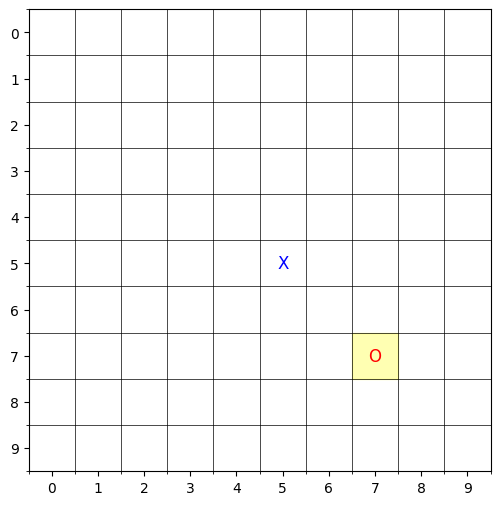

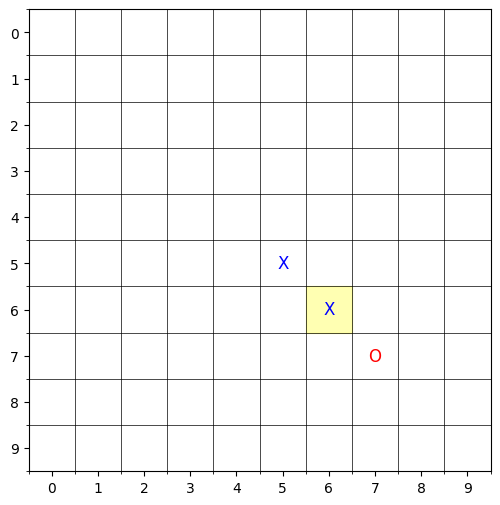

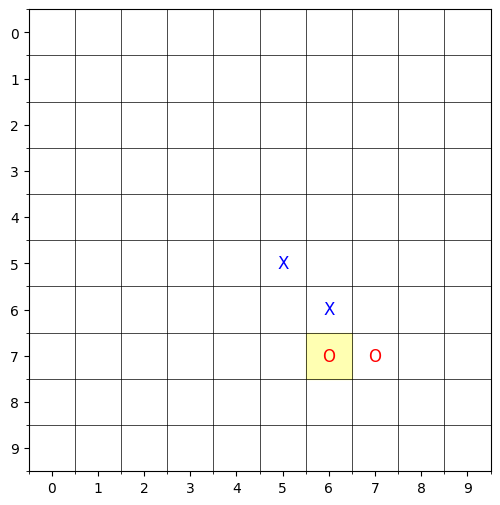

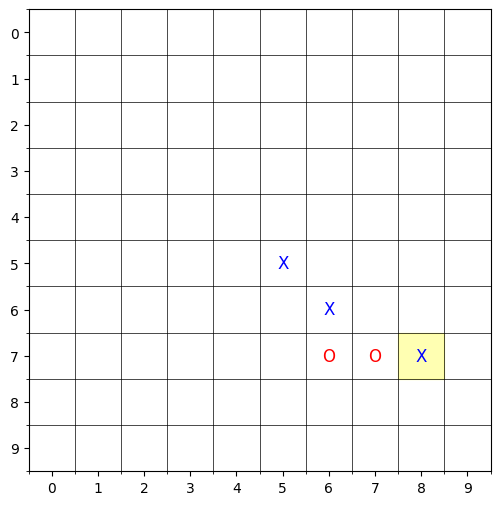

In [17]:
env = CaroEnv()
state = env.reset()

# Đánh thử vài nước:
env.step((7, 7))  # X
env.render()

env.step((6, 6))  # O
env.render()

env.step((7, 6))  # X
env.render()

env.step((7, 8))  # X
env.render()



In [18]:
import random

class SimpleBot:
    def __init__(self, board_size=10):
        self.board_size = board_size

    def select_action(self, board):
        # Bot là player -1
        for i in range(self.board_size):
            for j in range(self.board_size):
                if board[i, j] == 0:
                    board[i, j] = -1
                    if self.check_win(board, i, j, -1):
                        board[i, j] = 0
                        return (i, j)  # thắng luôn
                    board[i, j] = 0

        # Không thắng được → chọn ngẫu nhiên
        empty = list(zip(*np.where(board == 0)))
        return random.choice(empty)

    def check_win(self, board, x, y, player):
        directions = [(1,0), (0,1), (1,1), (1,-1)]
        for dx, dy in directions:
            count = 1
            for d in [1, -1]:
                nx, ny = x + d*dx, y + d*dy
                while 0 <= nx < self.board_size and 0 <= ny < self.board_size and board[nx, ny] == player:
                    count += 1
                    nx += d*dx
                    ny += d*dy
            if count >= 5:
                return True
        return False


In [19]:
"""
env = CaroEnv(board_size=10)
bot = SimpleBot(board_size=10)

state = env.reset()
done = False

while not done:
    # Agent (player 1) - chọn nước ngẫu nhiên từ các ô trống
    empty = list(zip(*np.where(state == 0)))
    action = random.choice(empty)
    state, reward, done, info = env.step(action)
    env.render()

    if done:
        if info['winner'] == 1:
            print("🎉 Game over! Agent (Player 1) wins!")
        elif info['winner'] == 0:
            print("🤝 Game over! It's a draw.")

        print(f"Final reward: {reward}")
        break

    # Bot (player -1)
    bot_action = bot.select_action(state)
    state, reward, done, info = env.step(bot_action)
    env.render()

    if done:
        if info['winner'] == -1:
            print("🤖 Game over! Bot (Player -1) wins!")
        elif info['winner'] == 0:
            print("🤝 Game over! It's a draw.")

        print(f"Final reward: {reward}")
        break
"""

'\nenv = CaroEnv(board_size=10)\nbot = SimpleBot(board_size=10)\n\nstate = env.reset()\ndone = False\n\nwhile not done:\n    # Agent (player 1) - chọn nước ngẫu nhiên từ các ô trống\n    empty = list(zip(*np.where(state == 0)))\n    action = random.choice(empty)\n    state, reward, done, info = env.step(action)\n    env.render()\n\n    if done:\n        if info[\'winner\'] == 1:\n            print("🎉 Game over! Agent (Player 1) wins!")\n        elif info[\'winner\'] == 0:\n            print("🤝 Game over! It\'s a draw.")\n\n        print(f"Final reward: {reward}")\n        break\n\n    # Bot (player -1)\n    bot_action = bot.select_action(state)\n    state, reward, done, info = env.step(bot_action)\n    env.render()\n\n    if done:\n        if info[\'winner\'] == -1:\n            print("🤖 Game over! Bot (Player -1) wins!")\n        elif info[\'winner\'] == 0:\n            print("🤝 Game over! It\'s a draw.")\n\n        print(f"Final reward: {reward}")\n        break\n'

In [58]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def play_with_bot(bot_class):
    # Khởi tạo môi trường và bot theo class truyền vào
    env = CaroEnv(board_size=10)
    bot = bot_class(env)
    state = env.reset()

    # Tạo các ô nhập và nút
    row_input = widgets.BoundedIntText(min=0, max=9, description='Hàng:')
    col_input = widgets.BoundedIntText(min=0, max=9, description='Cột:')
    play_button = widgets.Button(description="Đánh")
    reset_button = widgets.Button(description="🔄 Chơi lại", button_style='warning')
    output = widgets.Output()

    # Hàm xử lý khi bấm nút "Đánh"
    def on_play_click(b):
        nonlocal state
        with output:
            clear_output(wait=True)

            if env.done:
                print("🎮 Trò chơi đã kết thúc. Bấm 'Chơi lại' để bắt đầu ván mới.")
                display(row_input, col_input, play_button, reset_button)
                return

            x, y = row_input.value, col_input.value

            state, reward, done, info = env.step((x, y))
            if info.get("invalid", False):
                print("⛔ Ô đã đánh rồi! Hãy chọn ô khác.")
                env.render()
                display(row_input, col_input, play_button, reset_button)
                return


            # Người chơi đánh
            state, reward, done, info = env.step((x, y))
            env.render()

            if done:
                if info['winner'] == 1:
                    print("🎉 Bạn thắng!")
                elif info['winner'] == -1:
                    print("🤖 Bot thắng!")
                elif info['winner'] == 0:
                    print("🤝 Hòa!")
                else:
                    print("❌ Lỗi!")
                display(row_input, col_input, play_button, reset_button)
                return

            # Bot đánh
            bot_action = bot.select_action(state)
            state, reward, done, info = env.step(bot_action)
            print(f"🤖 Bot đánh vào ({bot_action[0]}, {bot_action[1]})")
            env.render()

            if done:
                if info['winner'] == 1:
                    print("🎉 Bot thắng!")
                elif info['winner'] == -1:
                    print("🤖 Ban thắng!")
                elif info['winner'] == 0:
                    print("🤝 Hòa!")
                else:
                    print("❌ Lỗi!")

            display(row_input, col_input, play_button, reset_button)

    # Hàm xử lý khi bấm nút "Chơi lại"
    def on_reset_click(b):
        nonlocal state, env, bot
        env = CaroEnv(board_size=10)
        bot = bot_class(e)
        center = env.board_size // 2
        state = env.reset()
        env.board[center, center] = 1
        env.current_player = -1
        env.last_move = (center, center)
        with output:
            clear_output(wait=True)
            print(f"🤖 Bot đánh vào ({center}, {center})")
            env.render()
            display(row_input, col_input, play_button, reset_button)


    # Gắn sự kiện
    play_button.on_click(on_play_click)
    reset_button.on_click(on_reset_click)

    # Hiển thị giao diện ban đầu
    with output:
        clear_output(wait=True)
        center = env.board_size // 2
        state = env.reset()
        env.board[center, center] = 1
        env.current_player = -1
        env.last_move = (center, center)
        print(f"🤖 Bot đánh vào ({center}, {center})")
        env.render()
        display(row_input, col_input, play_button, reset_button)

    display(output)


In [59]:
play_with_bot(SimpleBot)


Output()

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import random
import numpy as np

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = np.concatenate(states, axis=0)
        next_states = np.concatenate(next_states, axis=0)

        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.long),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32)
        )

    def __len__(self):
        return len(self.buffer)

    def get_data(self):
        return list(self.buffer)

    def load_data(self, data):
        self.buffer = deque(data, maxlen=self.capacity)


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual  # Skip connection
        return F.relu(out)

class CaroDQN(nn.Module):
    def __init__(self, board_size=10):
        super(CaroDQN, self).__init__()
        self.board_size = board_size

        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.res1 = ResidualBlock(64)
        self.res2 = ResidualBlock(64)

        self.flatten = nn.Flatten()
        conv_output_size = 64 * board_size * board_size
        self.fc1 = nn.Linear(conv_output_size, 512)
        self.fc2 = nn.Linear(512, board_size * board_size)

    def forward(self, x):  # x: [B, 2, H, W]
        x = F.relu(self.bn1(self.conv1(x)))  # [B, 32, H, W]
        x = F.relu(self.bn2(self.conv2(x)))  # [B, 64, H, W]

        x = self.res1(x)  # [B, 64, H, W]
        x = self.res2(x)  # [B, 64, H, W]

        x = self.flatten(x)  # [B, 64*H*W]
        x = F.relu(self.fc1(x))  # [B, 512]
        return self.fc2(x)       # [B, H*W]


In [25]:
def inject_blocking_scenarios(buffer, model, env, n=10):
    b = env.board_size
    samples = []

    for _ in range(n):
        board = np.zeros((b, b), dtype=np.int32)
        row = random.randint(0, b - 4)
        col = random.randint(0, b - 1)

        board[row][col] = 2
        board[row + 1][col] = 2
        board[row + 2][col] = 2

        if board[row + 3][col] != 0:
            continue

        env.current_player = 1
        board_norm = np.where(board == 1, 1.0, 0.0)
        board_norm = np.where(board == 2, -1.0, board_norm)
        player_map = np.full_like(board_norm, 1.0, dtype=np.float32)

        state = np.stack([board_norm, player_map])[np.newaxis, :, :, :].astype(np.float32)
        action = (row + 3, col)
        action_index = action[0] * b + action[1]

        next_board = board.copy()
        next_board[action] = 1
        board_norm_next = np.where(next_board == 1, 1.0, 0.0)
        board_norm_next = np.where(next_board == 2, -1.0, board_norm_next)
        player_map_next = np.full_like(board_norm_next, -1.0, dtype=np.float32)

        next_state = np.stack([board_norm_next, player_map_next])[np.newaxis, :, :, :].astype(np.float32)
        reward = 1.0
        done = False

        samples.append((state, action_index, reward, next_state, done))

    buffer.extend(samples)


In [26]:
import os
import random
import torch
import torch.nn.functional as F
import numpy as np
from google.colab import files  # Nếu dùng Colab
from IPython.display import FileLink  # Nếu dùng Kaggle


def train_dqn(env, model,
              episodes=500, batch_size=64,
              gamma=0.9, epsilon=1.0,
              epsilon_min=0.1, epsilon_decay=0.995,
              checkpoint_every=200, resume_path=None):

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    buffer = ReplayBuffer(10000)
    b = env.board_size

    all_losses = []
    rewards_log = []
    start_episode = 0

    # Load checkpoint nếu cần
    if resume_path is not None:
        checkpoint = torch.load(resume_path)
        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        buffer.load_data(checkpoint['buffer_data'])
        epsilon = checkpoint['epsilon']
        start_episode = checkpoint['episode'] + 1
        print(f"Resume training from episode {start_episode}")

    for episode in range(start_episode, episodes):
        raw = env.reset()
        board_norm = np.where(raw == 1, 1.0, 0.0)
        board_norm = np.where(raw == 2, -1.0, board_norm)
        current_player = env.current_player
        player_map = np.full_like(board_norm, 1.0 if current_player == 1 else -1.0, dtype=np.float32)
        state = np.stack([board_norm, player_map])[np.newaxis, :, :, :].astype(np.float32)

        total_reward = 0
        done = False

        while not done:
            if current_player == 1:
                action = env.get_strategic_action()
                if action is None:
                    if random.random() < epsilon:
                        empties = list(zip(*np.where(state[0, 0] == 0)))
                        if not empties:
                            break
                        action = random.choice(empties)
                    else:
                        with torch.no_grad():
                            q = model(torch.tensor(state, dtype=torch.float32))
                            q = q.view(b, b)
                            mask = (state[0, 0] == 0)
                            q[~mask] = -float('inf')
                            idx = torch.argmax(q).item()
                            action = (idx // b, idx % b)
                idx = action[0] * b + action[1]
            else:
                empties = list(zip(*np.where(state[0, 0] == 0)))
                if not empties:
                    break
                action = random.choice(empties)
                idx = action[0] * b + action[1]

            nxt_raw, reward, done, _ = env.step(action)
            board_norm = np.where(nxt_raw == 1, 1.0, 0.0)
            board_norm = np.where(nxt_raw == 2, -1.0, board_norm)
            player_map = np.full_like(board_norm, 1.0 if env.current_player == 1 else -1.0, dtype=np.float32)
            nxt = np.stack([board_norm, player_map])[np.newaxis, :, :, :].astype(np.float32)

            buffer.push(state, idx, reward, nxt, done)

            state = nxt
            total_reward += reward
            current_player = env.current_player

            if len(buffer) >= batch_size:
                s, a, r, s_next, d = buffer.sample(batch_size)
                q_vals = model(s).gather(1, a.unsqueeze(1)).squeeze()
                with torch.no_grad():
                    next_q = model(s_next).max(1)[0]
                    target = r + gamma * next_q * (1 - d)
                    target = torch.clamp(target, min=-1, max=1)

                loss = F.mse_loss(q_vals, target)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                all_losses.append(loss.item())

        rewards_log.append(total_reward)
        epsilon = max(epsilon * epsilon_decay, epsilon_min)

        if episode % 50 == 0:
            avg_loss = np.mean(all_losses[-50:]) if all_losses else 0.0
            avg_reward = np.mean(rewards_log[-50:]) if len(rewards_log) >= 50 else np.mean(rewards_log)
            print(f"Episode {episode:4d} | Avg Loss: {avg_loss:.4f} | Avg Reward (last 50): {avg_reward:.2f} | Epsilon: {epsilon:.3f}")

        # 🔒 Save checkpoint
        if (episode + 1) % checkpoint_every == 0:
            checkpoint_name = f"caro_dqn_ep{episode+1}.pth"
            torch.save({
                'episode': episode,
                'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict(),
                'epsilon': epsilon,
                'buffer_data': buffer.get_data()
            }, checkpoint_name)
            print(f"✔️ Saved checkpoint: {checkpoint_name}")

            # Tải file nếu đang ở Colab hoặc Kaggle
            try:
                files.download(checkpoint_name)  # Colab
            except Exception:
                try:
                    display(FileLink(checkpoint_name))  # Kaggle
                except Exception:
                    pass

    return all_losses, rewards_log


In [27]:
model = CaroDQN(board_size=10)
env = CaroEnv(board_size=10)
losses, rewards = train_dqn(env, model, episodes=601)

Episode    0 | Avg Loss: 0.0000 | Avg Reward (last 50): 6.00 | Epsilon: 0.995
Episode   50 | Avg Loss: 0.0014 | Avg Reward (last 50): 4.65 | Epsilon: 0.774
Episode  100 | Avg Loss: 0.0016 | Avg Reward (last 50): 4.27 | Epsilon: 0.603
Episode  150 | Avg Loss: 0.0021 | Avg Reward (last 50): 4.63 | Epsilon: 0.469
✔️ Saved checkpoint: caro_dqn_ep200.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Episode  200 | Avg Loss: 0.0012 | Avg Reward (last 50): 4.58 | Epsilon: 0.365
Episode  250 | Avg Loss: 0.0014 | Avg Reward (last 50): 4.58 | Epsilon: 0.284
Episode  300 | Avg Loss: 0.0012 | Avg Reward (last 50): 4.65 | Epsilon: 0.221
Episode  350 | Avg Loss: 0.0010 | Avg Reward (last 50): 4.59 | Epsilon: 0.172
✔️ Saved checkpoint: caro_dqn_ep400.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Episode  400 | Avg Loss: 0.0011 | Avg Reward (last 50): 4.59 | Epsilon: 0.134
Episode  450 | Avg Loss: 0.0010 | Avg Reward (last 50): 4.54 | Epsilon: 0.104
Episode  500 | Avg Loss: 0.0013 | Avg Reward (last 50): 4.52 | Epsilon: 0.100
Episode  550 | Avg Loss: 0.0008 | Avg Reward (last 50): 4.50 | Epsilon: 0.100
✔️ Saved checkpoint: caro_dqn_ep600.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Episode  600 | Avg Loss: 0.0011 | Avg Reward (last 50): 4.70 | Epsilon: 0.100


In [28]:
#torch.save(model.state_dict(), "/kaggle/working/caro_dqn_400.pth")

In [29]:
torch.save(model.state_dict(), "/kaggle/working/caro_dqn_final.pth")


In [56]:
from IPython.display import FileLink
FileLink("caro_dqn_ep400.pth")


/kaggle/working/caro_dqn_ep400.pth

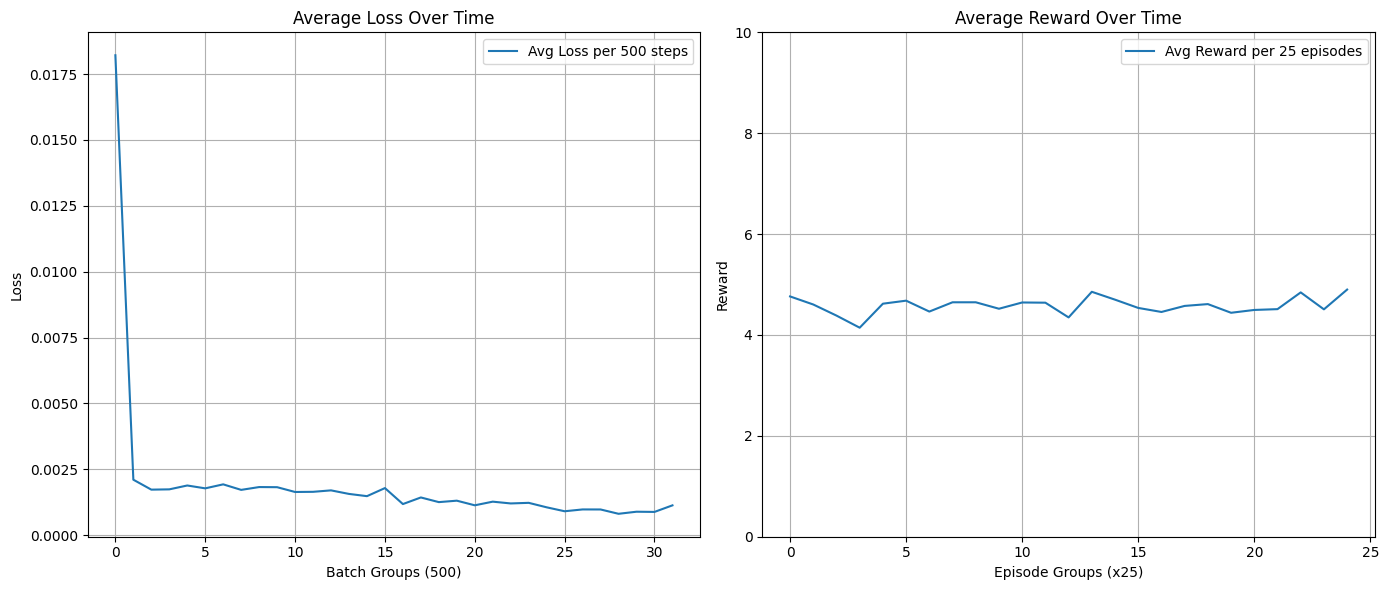

In [57]:
import matplotlib.pyplot as plt
import numpy as np

def plot_avg_loss_reward(all_losses, rewards_log, group_size=25):
    def avg_group(data, size):
        return [np.mean(data[i:i+size]) for i in range(0, len(data), size)]

    avg_losses = avg_group(all_losses, 500)
    avg_rewards = avg_group(rewards_log, group_size)

    plt.figure(figsize=(14, 6))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(avg_losses, label=f'Avg Loss per 500 steps')
    plt.xlabel(f'Batch Groups (500)')
    plt.ylabel('Loss')
    plt.title('Average Loss Over Time')
    plt.grid(True)
    plt.legend()

    # Reward
    plt.subplot(1, 2, 2)
    plt.plot(avg_rewards, label=f'Avg Reward per {group_size} episodes')
    plt.xlabel(f'Episode Groups (x{group_size})')
    plt.ylabel('Reward')
    plt.ylim(0, 10)  # 🔧 Giới hạn trục y từ 0 đến 20
    plt.title('Average Reward Over Time')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_avg_loss_reward(losses, rewards)

In [32]:
print(len(rewards))

601


In [34]:
#Load model
#model.load_state_dict(torch.load("caro_dqn_final.pth"))

#model.eval()

In [65]:
class TrainedDQNAgent:
    def __init__(self, model, env):
        self.model = model
        self.env = env  # gán env vào agent
        self.board_size = env.board_size

    def select_action(self, board):
        # 1. Gọi logic chiến thuật từ env
        move = self.env.get_strategic_action()
        if move is not None:
            return move

        # 2. Không có nước chiến thuật → dùng DQN chọn nước đi
        with torch.no_grad():
            agent_channel = (board == 1).astype(np.float32)
            opponent_channel = (board == -1).astype(np.float32)
            x = np.stack([agent_channel, opponent_channel], axis=0)
            x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(next(self.model.parameters()).device)

            q_values = self.model(x).view(self.board_size, self.board_size)
            mask = (torch.tensor(board) == 0)
            q_values[~mask] = -float('inf')
            idx = torch.argmax(q_values).item()
            return (idx // self.board_size, idx % self.board_size)


In [46]:
print("State shape:", state.shape)


State shape: (10, 10)


In [66]:
def play_match(env, agent, bot):
    state = env.reset()
    done = False
    turn = 0  # 0: agent, 1: bot

    while not done:
        if turn == 0:
            action = agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            state = next_state
            if done:
                winner = info.get('winner', None)
                if winner == 1:
                    return 1  # agent thắng
                elif winner == -1:
                    return -1  # bot thắng
                else:
                    return 0  # hòa
            turn = 1
        else:
            # Dùng state làm board cho bot
            board = state
            action = bot.select_action(board)
            next_state, reward, done, info = env.step(action)
            state = next_state
            if done:
                winner = info.get('winner', None)
                if winner == 1:
                    return 1
                elif winner == -1:
                    return -1
                else:
                    return 0
            turn = 0

    return 0


Agent vs SimpleBot: 47 wins, 3 losses, 0 draws in 50 matches.

Final match board:


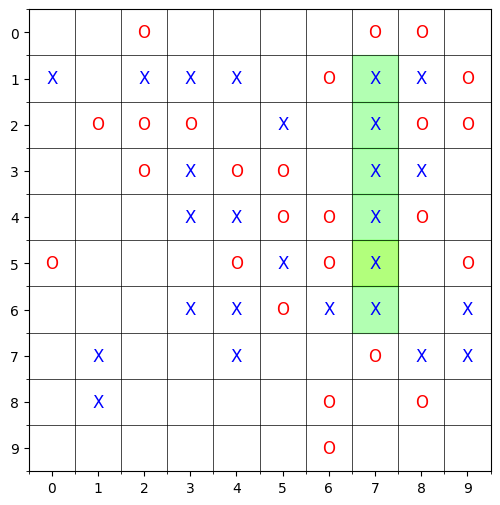

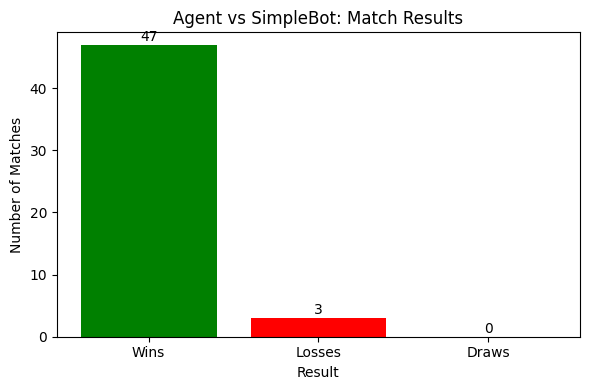

In [67]:
import matplotlib.pyplot as plt

def main():
    env = CaroEnv(board_size=10)
    agent = TrainedDQNAgent(model, env)
    bot = SimpleBot(board_size=10)

    wins = 0
    losses = 0
    draws = 0
    matches = 50

    last_env = None

    for i in range(matches):
        current_env = CaroEnv(board_size=10)
        result = play_match(current_env, agent, bot)
        if i == matches - 1:
            last_env = current_env

        if result == 1:
            wins += 1
        elif result == -1:
            losses += 1
        else:
            draws += 1

    print(f"Agent vs SimpleBot: {wins} wins, {losses} losses, {draws} draws in {matches} matches.")

    # Hiển thị trận cuối
    if last_env:
        print("\nFinal match board:")
        last_env.render()

    # Vẽ biểu đồ kết quả
    labels = ['Wins', 'Losses', 'Draws']
    counts = [wins, losses, draws]
    colors = ['green', 'red', 'gray']

    plt.figure(figsize=(6, 4))
    bars = plt.bar(labels, counts, color=colors)
    plt.title("Agent vs SimpleBot: Match Results")
    plt.xlabel("Result")
    plt.ylabel("Number of Matches")

    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, str(count), ha='center', va='bottom')

    plt.ylim(0, max(counts) + 2)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()

In [68]:
play_with_bot(lambda env: TrainedDQNAgent(model, env))
"can't play with human because it's still amateur"

Output()

"can't play with human because it's still amateur"